In [1]:
import numpy as np
import os, sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
import re
import concurrent.futures
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
import copy
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kmeans_pytorch import kmeans
from collections import OrderedDict
from contextlib import contextmanager

from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition
from sdv.evaluation.single_table import get_column_plot

import dask.dataframe as dpd
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

import gc
gc.collect()

np.random.seed(0)

/home/grads/l/lipai.huang/GAN_simulated_events/se_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = Client(n_workers=80) #192 totally

In [19]:
client.close()

In [3]:
print(torch.__version__, torch.cuda.is_available())
torch.cuda.set_device(0)

2.0.1+cu118 True


In [4]:
if torch.cuda.device_count() > 1:
    print(f"We have {torch.cuda.device_count()} GPUs!")

We have 8 GPUs!


In [5]:
# Plot geo map
def plot_map(gdf, col, vmin=0, vmax=300, figsize=(8, 6), dpi=200, notes='', to_path='', dots=[], title=True, s=1):
    plt.clf()
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Plot without specifying legend_kwds
    try:
        gdf.plot(ax=ax, column=col, cmap='coolwarm', vmin=vmin, vmax=vmax, cax=cax, s=s)
    except:
        gdf.plot(ax=ax, column=col, cmap='coolwarm', vmin=vmin, vmax=vmax, cax=cax)
    if dots:
        for dot in dots:
            gdf.loc[dot:dot].plot(ax=ax, linewidth=1, color='black', alpha=0.5)
            ax.text(gdf.loc[dot, 'x'], gdf.loc[dot, 'y'], str(dot), fontsize=12)

    # Create colorbar with custom font size
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, 
#                         label=col.upper(), 
                        shrink=.5)
#     cbar.ax.tick_params(labelsize=20)  # Set the font size for the colorbar
#     bd_gdf.boundary.plot(ax=ax, linewidth=1, color='k')
    # Change tick fontsize
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.scatter(gdf['x'], gdf['y'], s=1, c='k')
    
    # Change color bar fontsize
#     cbar.set_label(col.upper(), fontsize=20)
    if title:
        ax.set_title(f'{col.upper()}')
#     if not os.path.exists(f'plots/test/{notes}'):
#         os.mkdir(f'plots/test/{notes}')
#     fig.savefig(f'plots/test/{notes}/{col}.png')
    if to_path:
        fig.savefig(f'{to_path}')

In [4]:
coord_gdf = gpd.read_file('../src/coord/coord_gdf.shp')
coord_gdf = coord_gdf.drop(columns=['cell_rmse1', 'cell_r21', 'cell_rmse2', 'cell_r22', 'depth'])
coord_gdf

,x,y,ter,HUC12,region,channel,geometry
0,2.933766e+06,1.396557e+07,301.388702,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2933003.17..."
1,2.934966e+06,1.396557e+07,301.594696,Cypress Creek,0,0,"POLYGON ((2934366.000 13967369.160, 2934380.33..."
2,2.933766e+06,1.396437e+07,294.629181,Cypress Creek,0,0,"POLYGON ((2934366.000 13964974.635, 2934366.00..."
3,2.934966e+06,1.396437e+07,298.529877,Cypress Creek,0,0,"POLYGON ((2935566.000 13963774.635, 2934366.00..."
4,2.936166e+06,1.396437e+07,294.815002,Cypress Creek,0,0,"POLYGON ((2936766.000 13963774.635, 2935566.00..."
...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,54.643570,Whiteoak Bayou-Buffalo Bayou,2,1,"POLYGON ((3039427.707 13849492.726, 3038745.86..."
26297,3.039053e+06,1.385088e+07,59.625050,Addicks Reservoir,3,1,"POLYGON ((3039399.212 13851153.541, 3039405.50..."
26298,3.038396e+06,1.385006e+07,60.055576,Whiteoak Bayou-Buffalo Bayou,2,0,"POLYGON ((3038723.769 13850469.724, 3038724.68..."
26299,3.038392e+06,1.385087e+07,59.625050,Addicks Reservoir,3,0,"POLYGON ((3038721.900 13851266.014, 3038723.76..."


In [5]:
watershed_dict = coord_gdf.drop_duplicates(subset='HUC12').set_index('HUC12')['region'].to_dict()
watershed_dict

{'Cypress Creek': 0,
 'Greens Bayou': 1,
 'Whiteoak Bayou-Buffalo Bayou': 2,
 'Addicks Reservoir': 3,
 'Barker Reservoir': 4,
 'Hunting Bayou': 5,
 'Vince Bayou-Buffalo Bayou': 6,
 'Brays Bayou': 7,
 'Sims Bayou': 8}

In [6]:
scaler = MinMaxScaler()
xy_scaled = scaler.fit_transform(coord_gdf[['x', 'y']])

def load_and_scale(file_path, scale=False):
    df = pd.read_parquet(file_path)[['x', 'y', 'channel', 'ter', 'cumu_rain', 'peak_int', 'duration', 'depth']]
    if scale:
        df[['x', 'y']] = xy_scaled
    return df

file_paths = [f'../src/tables/data{i}.parquet' for i in range(1, len([f for f in os.listdir('../src/tables') if f.endswith('.parquet')]) + 1)]
events = [load_and_scale(file) for file in file_paths]
with ProgressBar():
    result = dpd.concat(events, axis=0)
events_df = result.compute()

In [7]:
events_df

,x,y,channel,ter,cumu_rain,peak_int,duration,depth
0,2.933766e+06,1.396557e+07,0,301.388702,3.001601,3.001601,1,3.866364
1,2.934966e+06,1.396557e+07,0,301.594696,3.127318,3.127318,1,2.150513
2,2.933766e+06,1.396437e+07,0,294.629181,3.211096,3.211096,1,3.595856
3,2.934966e+06,1.396437e+07,0,298.529877,3.260372,3.260372,1,2.782227
4,2.936166e+06,1.396437e+07,0,294.815002,3.309647,3.309647,1,2.787598
...,...,...,...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,1,54.643570,0.000000,0.000000,2,0.000000
26297,3.039053e+06,1.385088e+07,1,59.625050,0.000000,0.000000,2,0.000000
26298,3.038396e+06,1.385006e+07,0,60.055576,0.000000,0.000000,2,0.000000
26299,3.038392e+06,1.385087e+07,0,59.625050,0.000000,0.000000,2,0.000000


In [8]:
features = events_df[['channel', 'ter', 'cumu_rain', 'peak_int', 'duration']].values
targets = events_df[['depth']].values

X_train, X_temp, y_train, y_temp = train_test_split(
    features, targets, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
class DepthModelDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
batch_size = 51200

train_dataset = DepthModelDataset(X_train_scaled, y_train)
val_dataset = DepthModelDataset(X_val_scaled, y_val)
test_dataset = DepthModelDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [11]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_heads=8, num_layers=4, transform_dim=128):
        super(TransformerModel, self).__init__()
        self.input_transform = nn.Linear(input_dim, transform_dim)

        # Transformer specific layers
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=transform_dim, 
            nhead=num_heads,
            dim_feedforward=2048,  
            dropout=0.25  
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )

        # Output layer
        self.fc_out = nn.Linear(transform_dim, output_dim)

    def forward(self, src):
        src = self.input_transform(src)
        transformed = self.transformer_encoder(src)
        output = self.fc_out(transformed)
        return output


In [18]:
device = torch.device("cuda:0,1,2,3,4,5,6" if torch.cuda.is_available() else "cpu")

model = TransformerModel(train_dataset.features.shape[1]).to(device)
model = nn.DataParallel(model)

print(next(model.parameters()).is_cuda)

True


In [19]:
def rmse_loss(outputs, labels):
    mse_loss = nn.MSELoss()
    mse = mse_loss(outputs, labels)
    rmse = torch.sqrt(mse)
    return rmse

lr = 1e-5
num_epochs = 500
test_check_epochs = 25
# criterion = nn.MSELoss()
criterion = rmse_loss
optimizer = optim.Adam(model.parameters(), lr=lr)

history = {'train_loss': [], 'val_loss': [], f'test_{test_check_epochs}_loss': []}
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
checkpoint_path = os.path.join('../checkpoints', 'depth', f'best_model_{len([f for f in os.listdir("../checkpoints/depth") if f.endswith(".pth")])}_{lr}.pth')
depth_checkpoint_log_path = f'../logs/depth_{len(os.listdir("../logs"))-1}.log'

In [ ]:
for epoch in trange(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(device).float()
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device).float()
            labels = labels.to(device).float()
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    # Save model if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), checkpoint_path)
        with open(depth_checkpoint_log_path, 'a+') as depth_checkpoint_log_file:
            print(f'Epoch {epoch}: Saved model to {checkpoint_path} with val loss {val_loss:.4f}', file=depth_checkpoint_log_file)
            depth_checkpoint_log_file.flush()

    # Test phase every n epochs
    if (epoch+1) % test_check_epochs == 0:
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for features, labels in test_loader:
                features = features.to(device).float()
                labels = labels.to(device).float()
                outputs = model(features)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        
        # Average test loss
        test_loss /= len(test_loader)
        history[f'test_{test_check_epochs}_loss'].append((epoch, test_loss))

        # Optionally, print or log the test loss
        with open(depth_checkpoint_log_path, 'a+') as depth_checkpoint_log_file:
            print(f'Epoch {epoch}: Test loss {test_loss:.4f}', file=depth_checkpoint_log_file)
            depth_checkpoint_log_file.flush()
            
history_path = os.path.join('../logs', f'depth_modeling_{len(os.listdir("../logs"))-1}_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history, f)

In [ ]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

In [3]:
with open('../logs/depth_modeling_1_history.pkl', 'rb') as file:
    his = pickle.load(file)

In [5]:
his.keys()

dict_keys(['train_loss', 'val_loss', 'test_25_loss'])

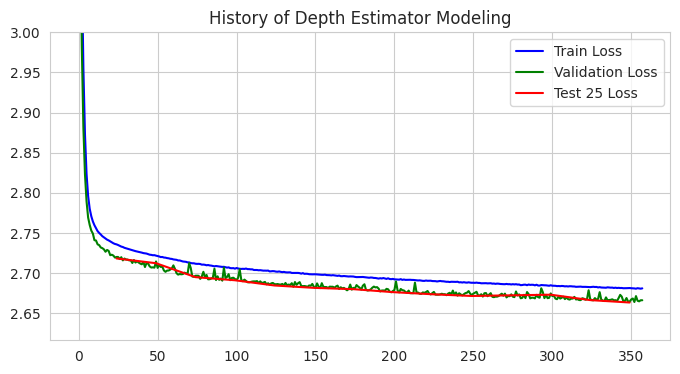

In [22]:
sns.set_style("whitegrid")

# Plotting
plt.figure(figsize=(8, 4))

# Plotting all three datasets on the same axes
sns.lineplot(data=his['train_loss'], label='Train Loss', color='blue')
sns.lineplot(data=his['val_loss'], label='Validation Loss', color='green')
test_25_loss_array = np.array(his['test_25_loss'])
sns.lineplot(x=test_25_loss_array[:, 0], y=test_25_loss_array[:, 1], label='Test 25 Loss', color='red')


# Adding title and legend
plt.title('History of Depth Estimator Modeling')
plt.legend()

plt.ylim(None, 3.0)

# Show the plot
plt.show()

array([2.7184401 , 2.71250621, 2.69517318, 2.69128932, 2.68479499,
       2.68183791, 2.68020348, 2.67652527, 2.67386803, 2.67172633,
       2.67254197, 2.67330198, 2.66660186, 2.66360039])

In [12]:
@contextmanager
def custom_torch_load(map_location):
    original_torch_load = torch.load

    def custom_load(*args, **kwargs):
        kwargs['map_location'] = map_location
        return original_torch_load(*args, **kwargs)

    torch.load = custom_load
    try:
        yield
    finally:
        torch.load = original_torch_load

In [13]:
map_location = 'cuda:0'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [14]:
device = torch.device('cuda:0')
model = TransformerModel(5).to(device)
tf_checkpoint = torch.load('../checkpoints/depth/best_model_0_1e-05.pth', map_location='cuda:0')
new_state_dict = OrderedDict()
for k, v in tf_checkpoint.items():
    # Remove 'module.' prefix
    name = k[7:]  # skip 'module.' (7 characters)
    new_state_dict[name] = v

# Load the adjusted state dict into your model
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [22]:
y_trues = y_test.reshape(-1,)

In [23]:
test_loader = DataLoader(test_dataset, batch_size=512000, shuffle=False)

In [27]:
model.eval()
y_preds = np.array([])
for _, (features, labels) in tqdm(enumerate(test_loader), total=len(test_loader), desc='Predicting'):
    with torch.no_grad():
        features = features.to(device).float()
        labels = labels.to(device).float()
        outputs = model(features)
        y_preds = np.append(y_preds, outputs.detach().to('cpu').numpy())

Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [11:56<00:00, 102.29s/it]


In [28]:
def calc_rmse(y_trues, y_preds, indices=[]):
    if len(indices) > 0:
        y_trues = y_trues[indices]
        y_preds = y_preds[indices]
    return np.round(np.sqrt(np.mean((y_preds[:] - y_trues[:]) ** 2)), 4)

def calc_r2(y_trues, y_preds, indices=[]):
    if len(indices) > 0:
        y_trues = y_trues[indices]
        y_preds = y_preds[indices]
    return np.round(1 - (np.sum((y_preds - y_trues)**2))/(np.sum((y_trues - np.mean(y_trues))**2)), 4)

In [29]:
test_rmse = calc_rmse(y_trues, y_preds)
test_r2 = calc_r2(y_trues, y_preds)
test_result_dict = {
    'rmse': test_rmse,
    'r2': test_r2,
}

In [30]:
channel_indices = np.where(scaler.inverse_transform(X_test_scaled)[:, 0] == 1)[0]
non_channel_indices = np.where(scaler.inverse_transform(X_test_scaled)[:, 0] == 0)[0]

In [31]:
channel_rmse = calc_rmse(y_trues, y_preds, channel_indices)
channel_r2 = calc_r2(y_trues, y_preds, channel_indices)
non_channel_rmse = calc_rmse(y_trues, y_preds, non_channel_indices)
non_channel_r2 = calc_r2(y_trues, y_preds, non_channel_indices)
test_result_dict['channel_rmse'] = channel_rmse
test_result_dict['channel_r2'] = channel_r2
test_result_dict['non_channel_rmse'] = non_channel_rmse
test_result_dict['non_channel_r2'] = non_channel_r2

In [32]:
test_result_dict

{'rmse': 2.6634,
 'r2': 0.6537,
 'channel_rmse': 4.1264,
 'channel_r2': 0.7278,
 'non_channel_rmse': 2.4133,
 'non_channel_r2': 0.4928}